<h1 align='center'> Customer Segmentation Using RFM Analysis

__In this notebook, we will conduct an explanatory data analysis on some of the important key metrics and walk through customer segmentation based on RFM (recency, frequency, and monetary value) principles using an online retail store dataset from Kaggle. We will follow these steps:__
> __1. Read in data and perform basic EDA__   
__2. Examine different key metrics__   
__3. Customer segmentation based on RFM__   
__4. Analyze customer segments__   

The dataset contains all purchases made for an e-commerce company based in the UK during one year period, with these columns:
- InvoiceNo: invoice number
- StockCode: item code
- Description: item description
- Quantity: item sold quantity
- InvoiceDate: invoice date
- UnitPrice: item unit price (The currency isn't clear. Here, we will assume it is USD.)
- CustomerID: customer ID
- Country: country of transaction


## Part 0. Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1. Reading in Data and EDA

In [2]:
df = pd.read_csv("~/Desktop/projects/Online_Retail/OnlineRetail.csv",  encoding='unicode_escape')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
# Get info
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
# Check missingness
df.isnull().sum().sort_values(ascending=False)

CustomerID     135080
Description      1454
Country             0
UnitPrice           0
InvoiceDate         0
Quantity            0
StockCode           0
InvoiceNo           0
dtype: int64

There are some observations with missing customer ID and/or product description.

In [6]:
# Check some rows with missing customer ID
df[df['CustomerID'].isnull()].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
414724,572477,20665,adjustment,-15,10/24/2011 13:39,0.00,NaN,United Kingdom
451091,575177,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,2,11/8/2011 18:41,2.08,NaN,United Kingdom


In [7]:
# Check some rows with missing Description
df[df['Description'].isnull()].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
143310,548684,72798C,NaN,-2,4/1/2011 16:46,0.0,NaN,United Kingdom
166619,550943,21316,NaN,-5,4/21/2011 15:51,0.0,NaN,United Kingdom


Some rows seem to be missing both description and customer ID's. 

In [8]:
# Check rows with negative quantities
df[df['Quantity']< 0].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
387849,570403,47574A,check,-61,10/10/2011 12:45,0.00,NaN,United Kingdom
171981,C551508,23194,GYMKHANA TREASURE BOOK BOX,-6,4/28/2011 18:16,2.25,13102.0,United Kingdom


In [9]:
# Check rows with negative quantities
df[df['UnitPrice']< 0].sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom


There are some rows with negative quantities and item unit price equal to or less than zero dollars.

There are some questions regarding data anomalies and oddities. 
- Missing description?   
- Missing customer ID?    
- Negative Quantities?    
- Unit price of zero?        

We will deal with them later.

### Feature Engineering

#### Order Value

In [10]:
# Create a value faature - amount of money spent on the particular order
df['value'] = df['Quantity'] * df['UnitPrice']

In [11]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,value
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00


#### Date Features

In [12]:
# Format the date feature - string to timestamp
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%m/%d/%Y %H:%M')

In [13]:
df['year_month'] = df['InvoiceDate'].dt.strftime('%Y-%m')
df['month'] = df['InvoiceDate'].dt.month
df['day'] = df['InvoiceDate'].dt.dayofweek + 1 # +1 to make Monday=1...Sunday=7
df['hour'] = df['InvoiceDate'].dt.hour

# Another way to create year_month
#df['year_month'] = df['InvoiceDate'].map(lambda x:100*x.year + x.month)

In [14]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,value,year_month,month,day,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,12,3,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,12,3,8


#### Orders with Negative Quantities

There are some orders with negative quantities. These could be cancelled or returned orders. For now, let's assume that orders with negative quantities were not actually sold; drop them from our dataset.

In [15]:
df = df[df['Quantity']>0]
print(df.shape)

(531285, 13)


#### Items with Zero or Negative Unit Price

There are some items with unit price of negative or zero dollars. Items priced at zero could mean they were free items. Negative unit price seems odd so let's drop them from the dataset.

In [16]:
print(df[df['UnitPrice'] == 0].shape)
print(df[df['UnitPrice'] < 0].shape)

# drop two rows with negative unit priced item
df = df[df['UnitPrice'] >= 0]

(1179, 13)
(2, 13)


   
      
## Part 2. Examine Different Key Metrics

### Top 5 Customers with Most Number of Orders

In [17]:
most_order = df.groupby(['CustomerID','Country'])['InvoiceNo'].count().sort_values(ascending=False)

In [18]:
pd.DataFrame(most_order.head(5))

,,InvoiceNo
CustomerID,Country,
17841.0,United Kingdom,7847
14911.0,EIRE,5677
14096.0,United Kingdom,5111
12748.0,United Kingdom,4596
14606.0,United Kingdom,2700


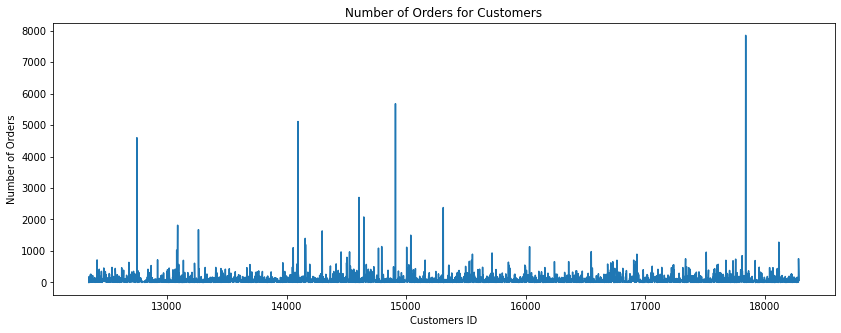

In [19]:
orders = df.groupby(['CustomerID','Country'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(14,5))
plt.plot(orders['CustomerID'], orders['InvoiceNo'])

plt.xlabel('Customers ID')
plt.ylabel('Number of Orders')
plt.title('Number of Orders for Customers')
plt.show()

In [20]:
orders['InvoiceNo'].describe()

count    4347.000000
mean       91.539913
std       228.596627
min         1.000000
25%        17.000000
50%        41.000000
75%       100.000000
max      7847.000000
Name: InvoiceNo, dtype: float64

__Most customers order fewer than 1000 orders, close to a couple of hundreds orders. However, there are a dozen of customers with a large number of orders.__

### Top 5 Customers with Most Number of Transactions

There can be more than one row for an InvoiceNo. This would mean that a customers bought multiple items in one transaction. Let's consider one Invoice Number as one transaction and look at the graph again.

In [21]:
df2 = df[['InvoiceNo', 'year_month', 'InvoiceDate','CustomerID','Country']]
unique_invoice = df2.drop_duplicates()

In [22]:
most_order = unique_invoice.groupby(['CustomerID','Country'])['InvoiceNo'].count().sort_values(ascending=False)
pd.DataFrame(most_order.head(5))

,,InvoiceNo
CustomerID,Country,
12748.0,United Kingdom,211
14911.0,EIRE,202
17841.0,United Kingdom,124
13089.0,United Kingdom,97
14606.0,United Kingdom,95


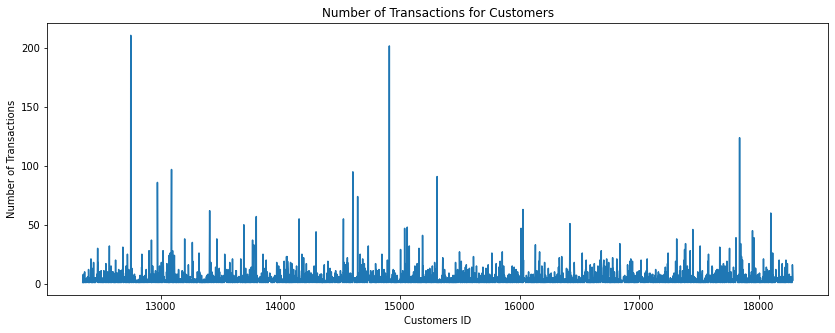

In [23]:
orders = unique_invoice.groupby(['CustomerID','Country'], as_index=False)['InvoiceNo'].count()

plt.subplots(figsize=(14,5))
plt.plot(orders['CustomerID'], orders['InvoiceNo'])

plt.xlabel('Customers ID')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions for Customers')
plt.show()

In [24]:
orders['InvoiceNo'].describe()

count    4347.000000
mean        4.270991
std         7.720866
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       211.000000
Name: InvoiceNo, dtype: float64

__The average number of transactions per customer is 4.27, with a standard deviation of 7.72. 75% of the customers made five or fewer transactions.__

### Top 5 Customers with Highest Money Spent

In [25]:
most_value = df.groupby(['CustomerID','Country'])['value'].sum().sort_values(ascending=False)

In [26]:
pd.DataFrame(most_value.head(5))

,,value
CustomerID,Country,
14646.0,Netherlands,280206.02
18102.0,United Kingdom,259657.30
17450.0,United Kingdom,194550.79
16446.0,United Kingdom,168472.50
14911.0,EIRE,143825.06


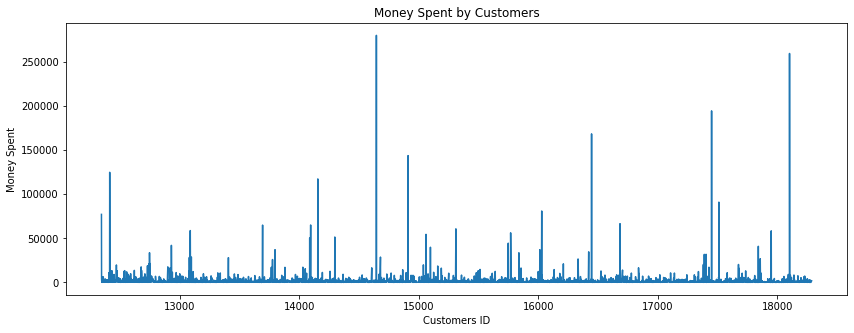

In [27]:
orders = df.groupby(['CustomerID','Country'], as_index=False)['value'].sum()

plt.subplots(figsize=(14,5))
plt.plot(orders['CustomerID'], orders['value'])

plt.xlabel('Customers ID')
plt.ylabel('Money Spent')
plt.title('Money Spent by Customers')
plt.show()

In [28]:
orders['value'].describe()

count      4347.000000
mean       2050.013320
std        8980.103578
min           0.000000
25%         307.430000
50%         671.960000
75%        1661.195000
max      280206.020000
Name: value, dtype: float64

__Most customers spend less than 2000 dollars (75% percentile is at 1610). However, we still see dozens of customers with large amount of money spent in their orders.__

### Transactions per Month

In [29]:
df2 = df[['InvoiceNo', 'year_month', 'InvoiceDate','month']]
df2 = df2.drop_duplicates()
df_monthly = pd.DataFrame(df2.groupby(['year_month','month'])['InvoiceNo'].count().reset_index())
df_monthly

,year_month,month,InvoiceNo
0,2010-12,12,1630
1,2011-01,1,1127
2,2011-02,2,1134
3,2011-03,3,1537
4,2011-04,4,1324
5,2011-05,5,1736
6,2011-06,6,1577
7,2011-07,7,1541
8,2011-08,8,1409
9,2011-09,9,1897


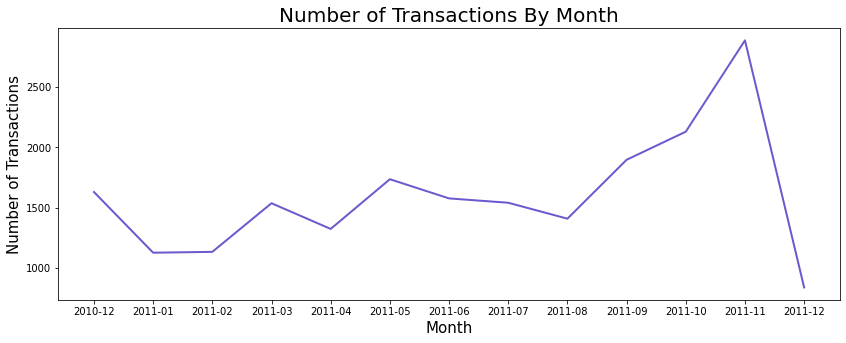

In [30]:
plt.figure(figsize=(14,5))
ax = sns.lineplot(x='year_month', y='InvoiceNo', data=df_monthly, color='slateblue', linewidth = 2)
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Transactions',fontsize=15)
ax.set_title('Number of Transactions By Month',fontsize=20)
#ax.set_xticklabels(("Dec '10","Jan '11","Feb '11","Mar '11","Apr '11","May '11", "Jun '11","Jul '11","Aug '11","Sep '11","Oct '11","Nov '11","Dec '11",),  rotation='horizontal', fontsize=12)
plt.show()

__We see variations in monthly transactions. Something to note here is Dec 2011 record seems very different from Dec 2010 records. Let's check if this is complete data.__

In [31]:
# Get first and last date in the data 
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


__Last date in this data is 12/9/2011 and it doesn't capture the full month of December in 2011. Therefore, we know that 2011 December data isn't complete.__

### Transactions by Day of the Week

In [32]:
df2 = df[['InvoiceNo', 'day', 'InvoiceDate']]
df2 = df2.drop_duplicates()
df_dow = pd.DataFrame(df2.groupby(['day'])['InvoiceNo'].count().reset_index())

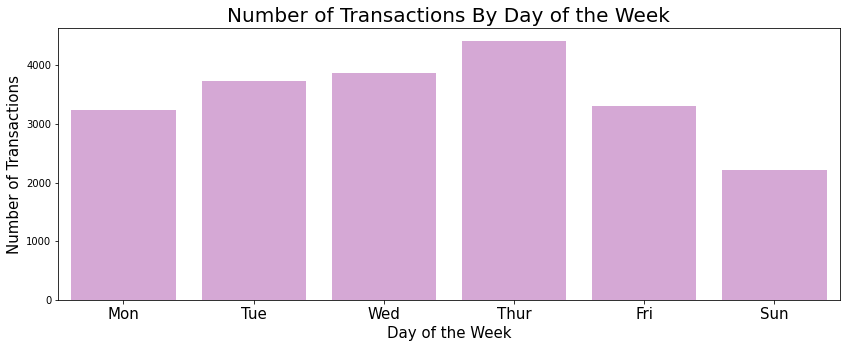

In [33]:
plt.figure(figsize=(14,5))
ax = sns.barplot(x=df_dow.day, y=df_dow.InvoiceNo, data=df_dow, color='plum')
ax.set_xlabel('Day of the Week',fontsize=15)
ax.set_ylabel('Number of Transactions',fontsize=15)
ax.set_title('Number of Transactions By Day of the Week',fontsize=20)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

__There is no transaction record for Saturday. This seems to be a data issue. If this happens in real business setting, we want to connect with the engineering team asap to investigate and resolve this issue.__

### Number of Transactions per Hour

In [34]:
df2 = df[['InvoiceNo', 'hour']]
df2 = df2.drop_duplicates()
df_hour = pd.DataFrame(df2.groupby(['hour'])['InvoiceNo'].count().reset_index())
df_hour

,hour,InvoiceNo
0,6,1
1,7,29
2,8,568
3,9,1538
4,10,2431
5,11,2473
6,12,3323
7,13,2818
8,14,2555
9,15,2474


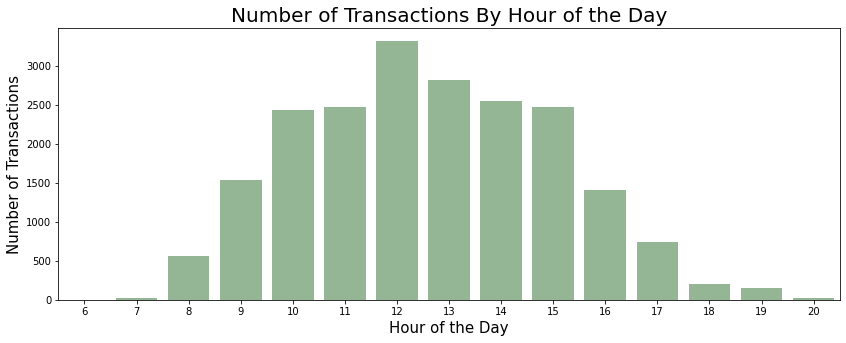

In [35]:
plt.figure(figsize=(14,5))
ax = sns.barplot(x=df_hour.hour, y=df_hour.InvoiceNo, data=df_hour, color='darkseagreen')
ax.set_xlabel('Hour of the Day',fontsize=15)
ax.set_ylabel('Number of Transactions',fontsize=15)
ax.set_title('Number of Transactions By Hour of the Day',fontsize=20)
plt.show()

__Most number of transaction usually happens between 10am and 3pm, with a peak at 12pm. People could be online shopping a lot during the lunch time. We might want to consider sending engaging e-mails or texts around lunch time. Another thing to note about this data is that we don't have order records from 8pm to 6am.__

### Distribution of Unit Price

In [36]:
df['UnitPrice'].describe()

count    531283.000000
mean          3.898954
std          35.876279
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [37]:
df[['UnitPrice','Description','Country']].sort_values(ascending=False, by='UnitPrice').head(10)

,UnitPrice,Description,Country
15017,13541.33,AMAZON FEE,United Kingdom
299982,11062.06,Adjust bad debt,United Kingdom
173382,8142.75,POSTAGE,United Kingdom
297723,4505.17,DOTCOM POSTAGE,United Kingdom
268028,4287.63,Manual,United Kingdom
422351,4161.06,Manual,France
422376,4161.06,Manual,France
406406,3949.32,Manual,Singapore
374542,3155.95,Manual,United Kingdom
347948,2653.95,Manual,Hong Kong


__From all the orders, the average unit price is about 4 dollars with standard deviation of 35. However, we see some high values that are greater than 2000. We need to investigate more to see if they are actual transaction records our customers made.__

### Countries with Most Orders

In [38]:
df_country = pd.DataFrame(df.groupby('Country')['InvoiceNo'].count().reset_index().sort_values(ascending=False,by='InvoiceNo'))

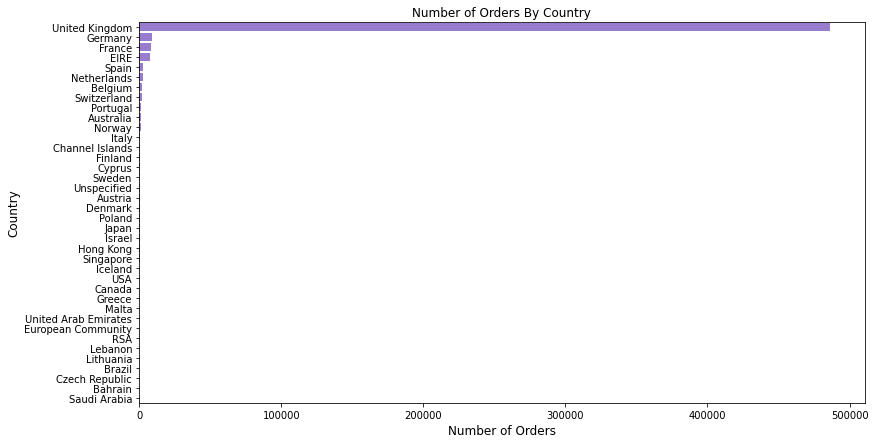

In [39]:
plt.figure(figsize=(13,7))
ax = sns.barplot(x='InvoiceNo',y='Country',  data=df_country, color='mediumpurple')
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders By Country', fontsize=12)
plt.show()

__The order numbers in the UK is overwhelmingly more than any other countries. This makes sense since this is a UK-based company.__ 

In [40]:
all_orders = df.shape[0]
UK_orders = df[df['Country']=='United Kingdom'].shape[0]
pct_UK = UK_orders/all_orders
print(f'{pct_UK*100:.2f}% of all orders are made in the UK.')

91.53% of all orders are made in the UK.


Let's look at it by country again without UK.

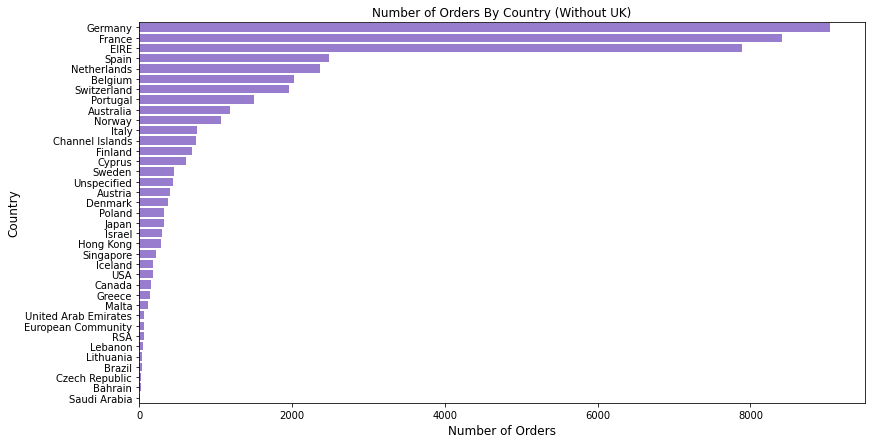

In [41]:
df_no_UK = df[df['Country']!='United Kingdom']
df_country = pd.DataFrame(df_no_UK.groupby('Country')['InvoiceNo'].count().reset_index().sort_values(ascending=False,by='InvoiceNo'))
plt.figure(figsize=(13,7))
ax = sns.barplot(x='InvoiceNo',y='Country',  data=df_country, color='mediumpurple')
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders By Country (Without UK)', fontsize=12)
plt.show()

__When ignoring the UK orders, the top three countries with highest number of orders are Germany, France, and EIRE(Ireland).__

### Countires with Highest Money Spent

In [42]:
df_value_country = pd.DataFrame(df.groupby('Country')['value'].sum().reset_index().sort_values(ascending=False, by='value'))

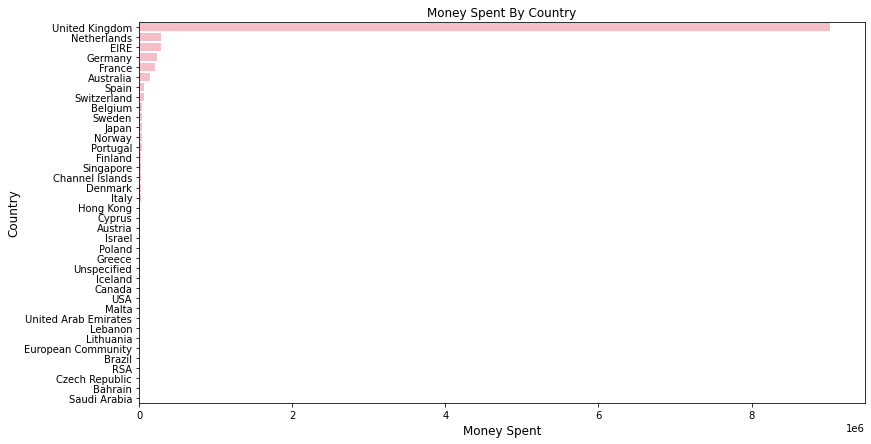

In [43]:
plt.figure(figsize=(13,7))
ax = sns.barplot(x='value', y='Country',  data=df_value_country, color='lightpink')
plt.xlabel('Money Spent', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent By Country', fontsize=12)
plt.show()

__Not surprisingly, UK has the highest money spent among all the countries.__

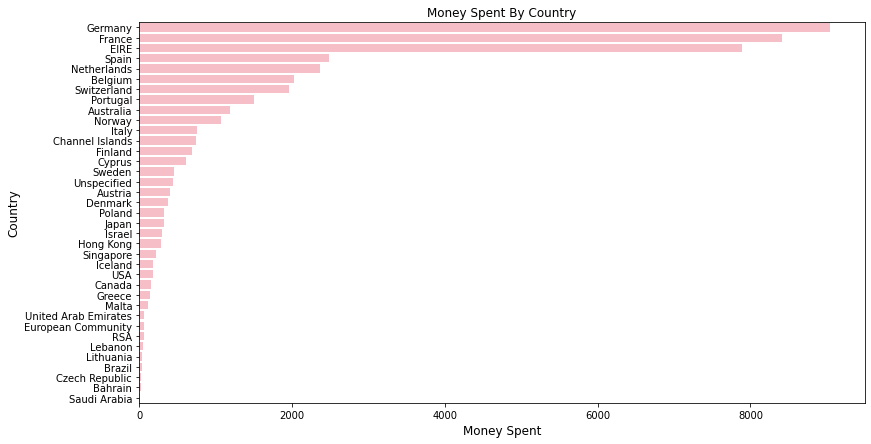

In [44]:
# Let's look at money spent by country without UK
df_value_country = pd.DataFrame(df.groupby('Country')['value'].sum().reset_index().sort_values(ascending=False, by='value'))
plt.figure(figsize=(13,7))
ax = sns.barplot(x='InvoiceNo',y='Country',  data=df_country, color='lightpink')
plt.xlabel('Money Spent', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent By Country', fontsize=12)
plt.show()

__Top three countries with highest money spent are Germany, France, and EIRE(Ireland) and they coincide with the top three countries with highest number of orders.__ 

### Monthly Revenue

In [45]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,value,year_month,month,day,hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,12,3,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,12,3,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,12,3,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,12,3,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,12,3,8


In [46]:
df_monthly = pd.DataFrame(df.groupby('year_month')['value'].sum().reset_index())

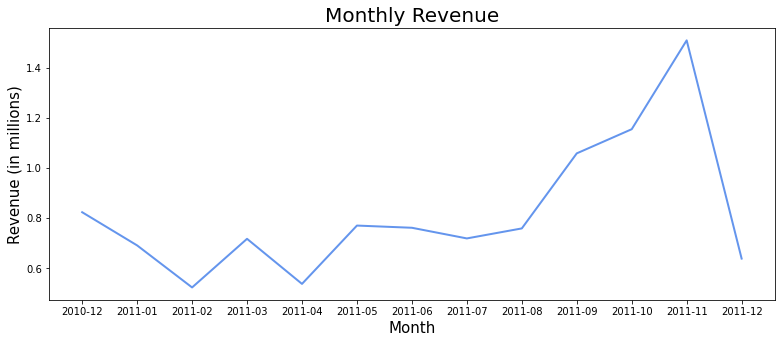

In [47]:
df_monthly = pd.DataFrame(df.groupby(['year_month'])['value'].sum().reset_index())
# Display numbers in Millions
df_monthly['value'] = df_monthly['value'] /1000000

plt.figure(figsize=(13,5))
ax = sns.lineplot(x='year_month', y='value', data=df_monthly, color='cornflowerblue', linewidth = 2)
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Revenue (in millions)',fontsize=15)
ax.set_title('Monthly Revenue',fontsize=20)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [48]:
# Drop 2011-12 record since December data is incomplete.
df_monthly = df_monthly.loc[0:12,:]
df_monthly['monthly_growth'] = df_monthly['value'].pct_change()

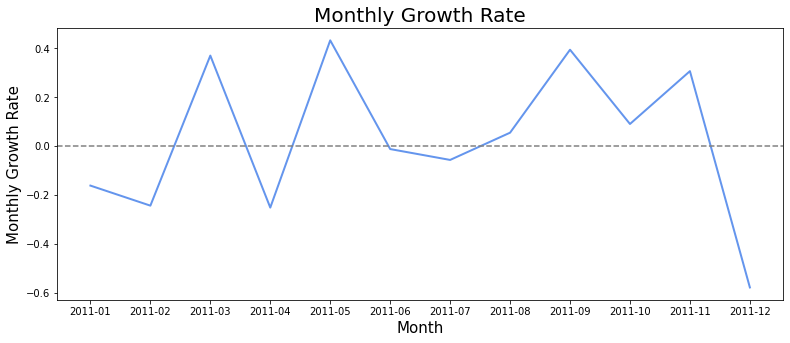

In [49]:
plt.figure(figsize=(13,5))
ax = sns.lineplot(x='year_month', y='monthly_growth', data=df_monthly, color='cornflowerblue', linewidth = 2)
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Monthly Growth Rate',fontsize=15)
ax.set_title('Monthly Growth Rate',fontsize=20)
ax.axhline(0, ls='--', color='grey')
plt.show()

__There are some dips in the monthly growth rate, with the biggest drop in April 2011 followed by another drop in June 2011. Some of the possible reasons for these dips are: fewer customers made orders, customers made orders less frequently, or customers bought less expensive items. We should investigate why these revenue drops happened.__

### Number of Active Customers by Month

In [50]:
# count number of unique Customer IDs per month
df_monthly_customers = df.groupby('year_month')['CustomerID'].nunique().reset_index()
df_monthly_customers

,year_month,CustomerID
0,2010-12,885
1,2011-01,741
2,2011-02,758
3,2011-03,974
4,2011-04,856
5,2011-05,1056
6,2011-06,991
7,2011-07,949
8,2011-08,935
9,2011-09,1266


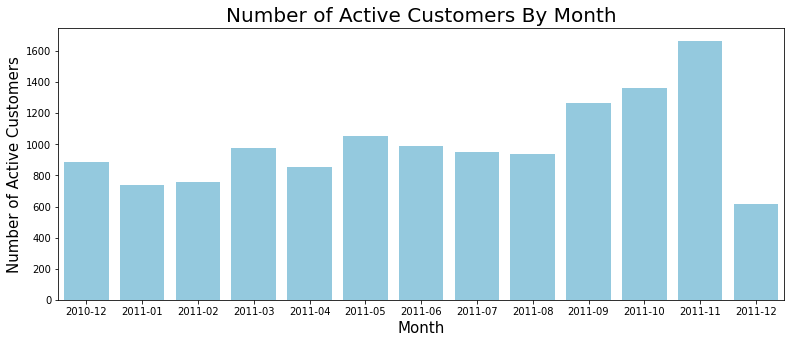

In [51]:
plt.figure(figsize=(13,5))
ax = sns.barplot(x='year_month', y='CustomerID', data=df_monthly_customers, color='skyblue')
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Active Customers',fontsize=15)
ax.set_title('Number of Active Customers By Month',fontsize=20)
plt.show()

__There was a slight decrease in number of active customers from March to April and again from May to June.__ 

### Number of Transactions by Month

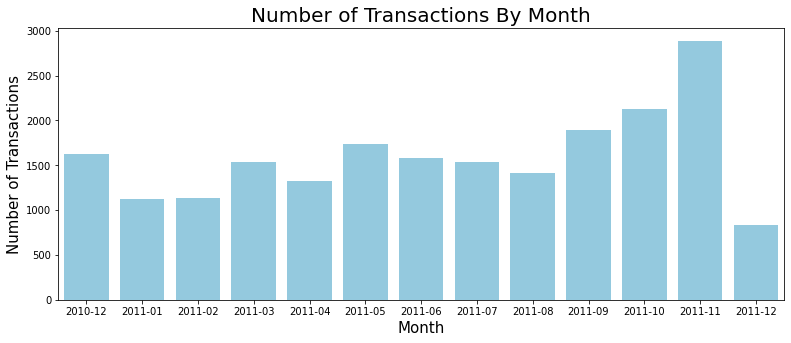

In [52]:
#Let's revisit the number of transactions by month
df2 = df[['InvoiceNo', 'year_month', 'InvoiceDate','month']]
df2 = df2.drop_duplicates()
df_monthly = pd.DataFrame(df2.groupby(['year_month','month'])['InvoiceNo'].count().reset_index())

plt.figure(figsize=(13,5))
ax = sns.barplot(x='year_month', y='InvoiceNo', data=df_monthly, color='skyblue')
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Transactions',fontsize=15)
ax.set_title('Number of Transactions By Month',fontsize=20)
plt.show()

__The number of transactions shows similar patterns as the number of customrs (a decrease from March to April).__ 

### Average Revenue Per Transaction

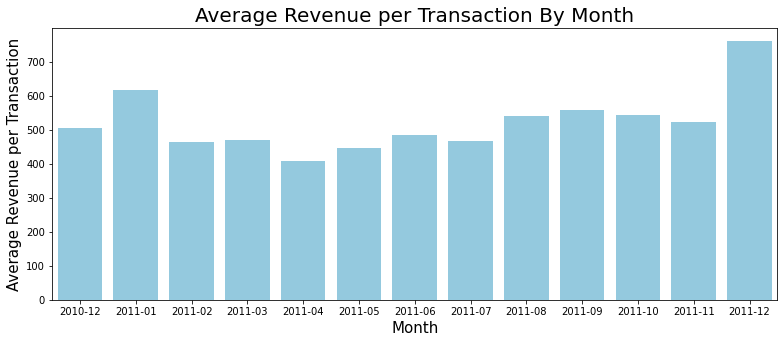

In [53]:
# Sum all the values in a transaction
df_revenue = pd.DataFrame(df.groupby(['year_month', 'InvoiceNo'])['value'].sum().reset_index())
# Take an average of the transaction values by month
df_revenue_transaction = pd.DataFrame(df_revenue.groupby('year_month').mean().reset_index())

plt.figure(figsize=(13,5))
ax = sns.barplot(x='year_month', y='value', data=df_revenue_transaction, color='skyblue')
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Average Revenue per Transaction',fontsize=15)
ax.set_title('Average Revenue per Transaction By Month',fontsize=20)
plt.show()

__There is a drop in average revenue per transaction from March to April. 
However, we should note that there is a increase from May to June. This could mean that even though average revenue per transaction was higher in June than May, we still saw a decrease in overall revenue due to fewer number of orders/customers.__

### Monthly Revenue by Customer Type

We will calculate the number of customers whose first-ever order was placed for each month. Then we will explore monthly revenue pattern by customer type.

In [54]:
# Get dates of first order per customer
df_first_order = df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
df_first_order.columns = ['CustomerID','first_order']
df = pd.merge(df, df_first_order, on='CustomerID')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,value,year_month,month,day,hour,first_order
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,12,3,8,2010-12-01 08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,12,3,8,2010-12-01 08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,12,3,8,2010-12-01 08:26:00


In [55]:
# Create a column called user type (new or existing)
df['year_month2'] = pd.to_datetime(df['year_month'])
df['user_type'] = 'new'
df.loc[df['year_month2'] > df['first_order'], 'user_type'] = 'existing'

df_revenue = df.groupby(['year_month','user_type'])['value'].sum().reset_index()
# drop last two rows - december 2011
df_revenue = df_revenue.loc[:22,:]

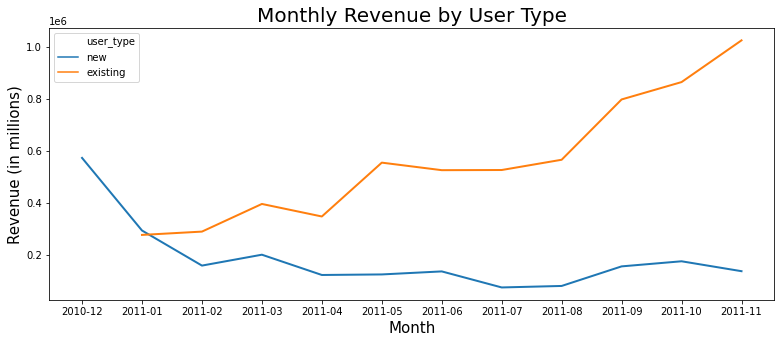

In [56]:
plt.figure(figsize=(13,5))
ax = sns.lineplot(x='year_month', y='value', data=df_revenue, hue='user_type', linewidth = 2)
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Revenue (in millions)',fontsize=15)
ax.set_title('Monthly Revenue by User Type',fontsize=20)
plt.show()

__Monthly revenue for existing customers is growing, except for a slight dip from March to April. However, monthly revenue from new customers is showing a negative trend.__

### Number of Customer by Type

Let's graph number of customers to see if a decreasing pattern in revenue by new customers is driven by a decreasing pattern in number of new customers.

In [57]:
# Count unique number of userID's per month
df2 = df[['year_month','user_type','CustomerID']]
df2 = df2.drop_duplicates()
df_users = pd.DataFrame(df2.groupby(['year_month','user_type'])['CustomerID'].count().reset_index())
df_users = df_users.loc[1:22,:]

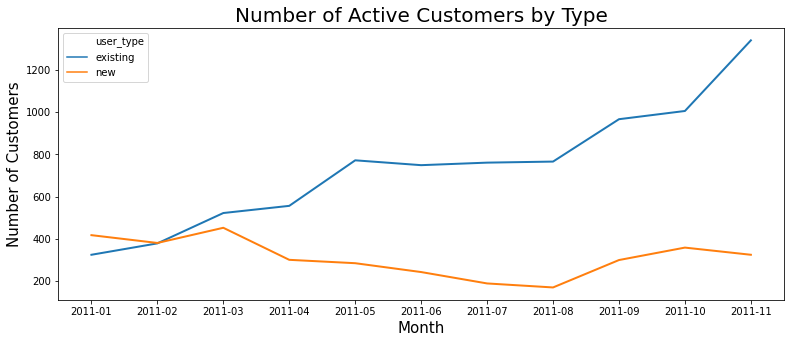

In [58]:
plt.figure(figsize=(13,5))
ax = sns.lineplot(x='year_month', y='CustomerID', data=df_users, hue='user_type', linewidth = 2)
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Customers',fontsize=15)
ax.set_title('Number of Active Customers by Type',fontsize=20)
plt.show()

Number of existing customers accumulates over time so the positive trend line might seem obvious. However, it is still of importance since it indicates that the customers are returning to place more orders over time.
Number of new customers has decreased from March to August. We might want to focus our marketing on getting more customers.  

## Part 3. Customer Segmentation based on RFM

__RFM is a great way for customer behavioral segmentation based on:__

- Recency: How recent was their last purchase?
- Frequency: How often have they purhcased?
- Monetary Value: How much they have spent?

### Calculate RFM values

In [59]:
# Last day in our data
max_date = df['InvoiceDate'].max()

# Create a RFM table for each customer
RFM = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (max_date - x.max()).days, # number of days since the last order
                                    'InvoiceNo': lambda x: len(x.unique()), # total number of transactions
                                    'value': lambda x: x.sum()}) # amount of total purchases

RFM.columns=['recency','frequency','monetary']
RFM.sample(3)

,recency,frequency,monetary
CustomerID,,,
13272.0,30,2,276.56
13318.0,0,3,640.76
17720.0,25,4,1195.94


In [60]:
# Merge RFM table with the original df to do some checks
df = pd.merge(df, RFM, on='CustomerID')

In [61]:
# Let's look at a customer of customers with frequency == 2
samp1 = df.query('frequency==2')
# From samp1, I randomly chose a customerID
samp = df.query('CustomerID==16250.0')
samp.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,value,year_month,month,day,hour,first_order,year_month2,user_type,recency,frequency,monetary
3969,536388,21754,HOME BUILDING BLOCK WORD,3,2010-12-01 09:59:00,5.95,16250.0,United Kingdom,17.85,2010-12,12,3,9,2010-12-01 09:59:00,2010-12-01,new,260,2,389.44


In [62]:
# Check Recency
print('Number of days since the last order:',(max_date - samp['InvoiceDate'].max()).days)
# Check Freqency
print('Number of unique invoice Numbers:', samp['InvoiceDate'].nunique())
# Check monetary value
print('Total amount of money spent:', samp['value'].sum())

Number of days since the last order: 260
Number of unique invoice Numbers: 2
Total amount of money spent: 389.44


In [63]:
quartiles = RFM.quantile(q=[0.25,0.5,0.75])
quartiles

,recency,frequency,monetary
0.25,17.0,1.0,307.245
0.50,50.0,2.0,674.450
0.75,141.0,5.0,1661.640


The table above shows the values for each of recency, frequency, and monetary values at 25, 50, and 75 percentiles.

In [64]:
quartiles = quartiles.to_dict()
RFM_segmented = RFM

### Distributions of R,F, and M

#### Recency

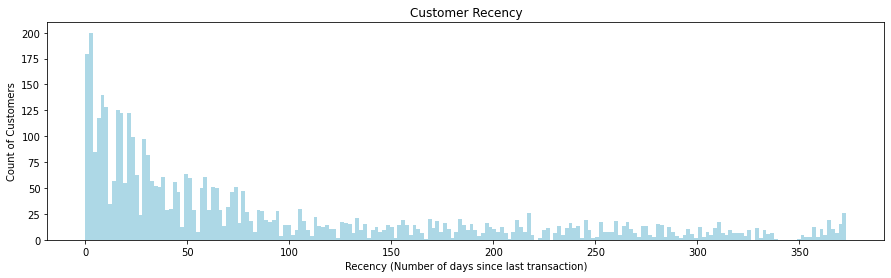

In [65]:
# Recency
plt.figure(figsize=(15,4))
RFM_segmented['recency'].hist(bins=200, color='lightblue')
plt.xlabel("Recency (Number of days since last transaction)")
plt.ylabel("Count of Customers")
plt.title("Customer Recency")
plt.grid(False)
plt.show()

__Distribution of recency is extremely right skewed with a very long tail. Many customers made an order within the last two months (~60 days) but there are still a significant number of customers whose last transaction was more than 100 days ago.__

#### Frequency

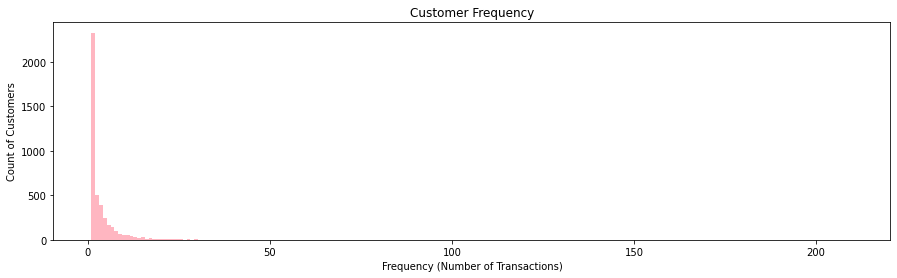

In [66]:
# Frequency
plt.figure(figsize=(15,4))
RFM_segmented['frequency'].hist(bins=200, color='lightpink')
plt.xlabel("Frequency (Number of Transactions)")
plt.ylabel("Count of Customers")
plt.title("Customer Frequency")
plt.grid(False)
plt.show()

There is a huge number of customers with frequency of one or two. 

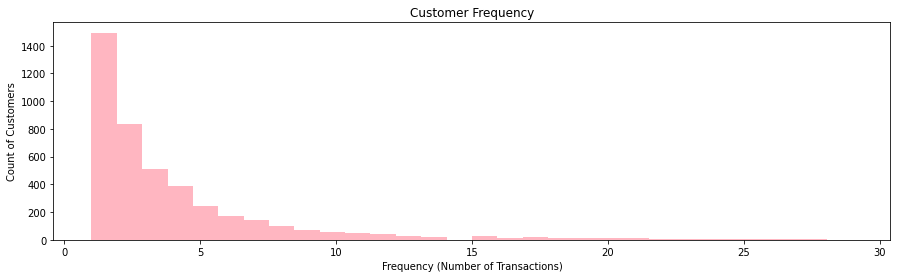

In [67]:
# Looking at customer with frequency fewer than 30
plt.figure(figsize=(15,4))
sample1 = RFM_segmented.query('frequency < 30')
sample1['frequency'].hist(bins=30, color='lightpink')
plt.xlabel("Frequency (Number of Transactions)")
plt.ylabel("Count of Customers")
plt.title("Customer Frequency")
plt.grid(False)
plt.show()

In [68]:
RFM_segmented['frequency'].value_counts(normalize=True).head(5)

1    0.344319
2    0.192441
3    0.117078
4    0.089191
5    0.056004
Name: frequency, dtype: float64

More than 70% of the customers had fewer than five transactions.

#### Monetary Value

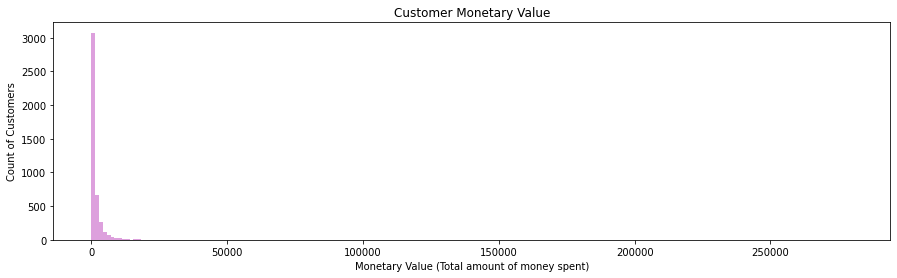

In [69]:
# Monetary Value
plt.figure(figsize=(15,4))
RFM_segmented['monetary'].hist(bins=200,color='plum')
plt.xlabel("Monetary Value (Total amount of money spent)")
plt.ylabel("Count of Customers")
plt.title("Customer Monetary Value")
plt.grid(False)
plt.show()

Most custeomrs seem to have less than $10,000 but therer are some customers with extreme values (this would need more investigation to see if those transactions are legitimate).

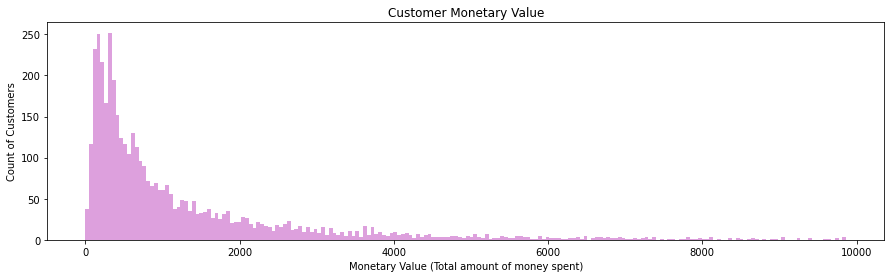

In [70]:
# Look at customers with less than $10000 transaction values
sample1 = RFM_segmented.query('monetary < 10000')
plt.figure(figsize=(15,4))

sample1['monetary'].hist(bins=200,color='plum')
plt.xlabel("Monetary Value (Total amount of money spent)")
plt.ylabel("Count of Customers")
plt.title("Customer Monetary Value")
plt.grid(False)
plt.show()

In [71]:
RFM_segmented.query('monetary < 2000').shape[0]/RFM_segmented.shape[0]

0.7918875316893293

About 80% of the customers have spent less than $2000.

### Assign scores

In [72]:
# Recency: the smaller the value is, the better.
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.5]:
        return 2
    elif x <= d[p][.75]:
        return 3
    else:
        return 4

# Frequency and Monetary value: the bigger it is, the better.
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.5]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [73]:
RFM_segmented['R_score'] = RFM_segmented['recency'].apply(RScore, args=('recency',quartiles,))
RFM_segmented['F_score'] = RFM_segmented['frequency'].apply(FMScore, args=('frequency',quartiles,))
RFM_segmented['M_score'] = RFM_segmented['monetary'].apply(FMScore, args=('monetary',quartiles,))
RFM_segmented.head(3)

,recency,frequency,monetary,R_score,F_score,M_score
CustomerID,,,,,,
12346.0,325,1,77183.60,4,4,1
12347.0,1,7,4310.00,1,1,1
12348.0,74,4,1797.24,3,2,1


In [74]:
# Concatenate individual scores
RFM_segmented['RFM_score'] = RFM_segmented['R_score'].map(str)+RFM_segmented['F_score'].map(str)+RFM_segmented['M_score'].map(str)
RFM_segmented.sample(3)

,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
CustomerID,,,,,,,
16923.0,11,19,7247.61,1,1,1,111
14984.0,18,2,213.27,2,3,4,234
13061.0,71,1,248.61,3,4,4,344


__Customers with RFM score 111 is the best customer - they are customers who purchased very recently; make purchases frequently; made a large sum of purchase.__

__We can have 64 = 4 * 4 * 4 different types of customers based on the RFM scores.__

In [75]:
best_customers = RFM_segmented[RFM_segmented['RFM_score']=='111']
print('There are', best_customers.shape[0], 'customers with RFM=="111"')
best_customers.sample(5)

There are 462 customers with RFM=="111"


,recency,frequency,monetary,R_score,F_score,M_score,RFM_score
CustomerID,,,,,,,
12584.0,3,9,2338.15,1,1,1,111
18230.0,8,7,2810.20,1,1,1,111
15482.0,15,12,11054.96,1,1,1,111
15105.0,17,7,2298.93,1,1,1,111
17519.0,16,6,1844.02,1,1,1,111


__There are more than 460 customers with RFM score of 111. These are customers who have made an order in the past 17 days, made five or more orders, and spent more than 1661.64 dollars within the past year (12/1/2010-12/9-2011).__  

In [76]:
# Let's also calculate the overall score, summing up  R,F,M values
RFM_segmented['Overall_score'] =RFM_segmented['R_score']+RFM_segmented['F_score']+RFM_segmented['M_score']

In [77]:
RFM_segmented.groupby('Overall_score')['recency','frequency','monetary'].mean()

/Users/jil380/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,recency,frequency,monetary
Overall_score,,,
3,6.357143,16.155844,9457.140887
4,19.459701,8.122388,4175.362209
5,28.295455,5.141414,2421.982273
6,41.525822,3.889671,1455.602209
7,58.869048,3.016667,1191.030476
8,74.619048,2.288095,781.593910
9,91.098739,1.676471,714.813634
10,111.330490,1.351812,385.079576
11,181.354970,1.127789,287.979412


To make things simpler, we can take it one step further and group customers into three categories based on their overall score:

- 3 to 5: High Value
- 6 to 8: Mid Value
- 9 to 12: Low Value


In [78]:
RFM_segmented['type'] = 'Low-Value'
RFM_segmented.loc[RFM_segmented['Overall_score']<=8, 'type'] = 'Mid-Value'
RFM_segmented.loc[RFM_segmented['Overall_score']<=5, 'type'] = 'High-Value'
RFM_segmented.sample(5)

,recency,frequency,monetary,R_score,F_score,M_score,RFM_score,Overall_score,type
CustomerID,,,,,,,,,
16168.0,10,27,3787.60,1,1,1,111,3,High-Value
13769.0,1,10,2796.51,1,1,1,111,3,High-Value
15725.0,14,1,415.25,1,4,3,143,8,Mid-Value
13860.0,0,5,1245.90,1,2,2,122,5,High-Value
17737.0,8,2,168.24,1,3,4,134,8,Mid-Value


### Visualize Customer Categories

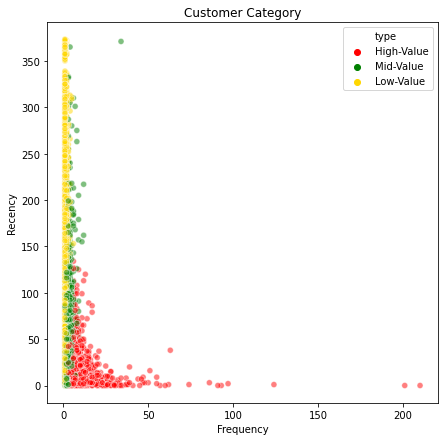

In [79]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x='frequency', y='recency', data=RFM_segmented, 
                     hue='type', hue_order=('High-Value','Mid-Value','Low-Value'),
                     palette=('red','green','gold'),alpha=0.5)
ax.set_xlabel("Frequency")
ax.set_ylabel("Recency")
ax.set_title("Customer Category")
plt.show()

__In general, our high value customers have lower number of days since the last order with higher frequency. In contrast, low value customers seem to be people who made orders only once or twice.__

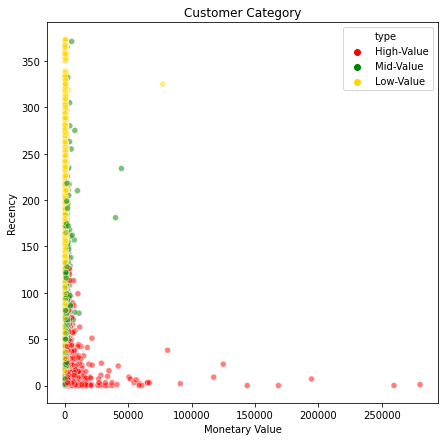

In [80]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x='monetary', y='recency', data=RFM_segmented, 
                     hue='type', hue_order=('High-Value','Mid-Value','Low-Value'),
                     palette=('red','green','gold'),alpha=0.5)
ax.set_xlabel("Monetary Value")
ax.set_ylabel("Recency")
ax.set_title("Customer Category")
plt.show()

__Again, high value customers have made orders more recently. Also, they have spent much more than the low and mid value customers.__

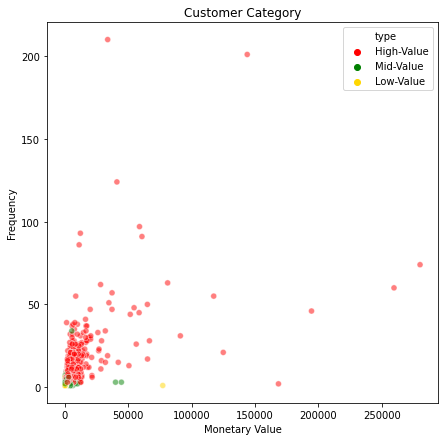

In [81]:
plt.figure(figsize=(7,7))
ax = sns.scatterplot(x='monetary', y='frequency', data=RFM_segmented, 
                     hue='type', hue_order=('High-Value','Mid-Value','Low-Value'),
                     palette=('red','green','gold'),alpha=0.5)
ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_title("Customer Category")
plt.show()

__Customer type is a little more difficult to distinguish from this plot.__

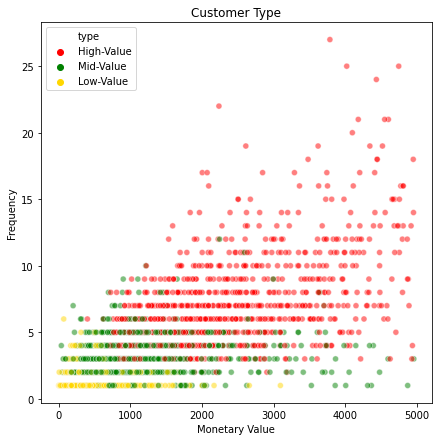

In [82]:
# Focusing on the cluttered area
RFM_segmented_sample = RFM_segmented.query('monetary < 5000 and frequency < 30')

plt.figure(figsize=(7,7))
ax = sns.scatterplot(x='monetary', y='frequency', data=RFM_segmented_sample, 
                     hue='type', hue_order=('High-Value','Mid-Value','Low-Value'),
                     palette=('red','green','gold'),alpha=0.5)
ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency")
ax.set_title("Customer Type")
plt.show()

__High value customers are generally spotted on upper right on this scatterplot, showing higher frequency and monetary values. In contrast, low value customers are more towards bottom left.__  

## Part 4. Analyze Customer Segments

We see different customer segments based on the their RFM scores. Let's delve into few interesting segments and think about action steps we can take.


- __Champions__ are most valuable customers who bought most recently, most often, and spent the most. Their current and future values are very high. We should reward them for coming back to our online store, . Also, we can offer product recommendation or information that fits their online behavior. (RFM score: 111)       
        
        
- __New Customers__ can have high potential values, even if their current values are not as high (they might have low fequency). We can send them special welcome offers to encourage more visits and provide onboarding support. We should focus on building relationships with these customers. (RFM score: 14X)       
   
      
- __Loyalists__ are the repeat customers who regularly engage with our brand and campaigns. They are customers who could promote our brand and refer friends. We should reward them and find ways to engage them more actively. (RFM score: 121, 211)
     
                
- __Potential Loyalists__ are our recent customers with average fequency and high amount spent. We can engage with them by offering membership, loyalty programs or product recommendations to help them become loyal customers. (RFM score: 212, 122, 221)  
        
        
- __At Risk Customers__ are customers who used to buy often and spend high value, but haven't purchased recently. By sending them personalized reactivation campaigns and relevant promotions, we can try to bring them back to engage with our brand more frequently. We can also send surveys to discover why they haven't been engaging with our brand. (RFM score: 311, 411)
      
            
        
        




__In this notebook, we have performed RFM customer segmentation on the online retail data. RFM analysis is useful for guiding how a company should interact with their customers so that they can achieve an optimal return on investments from their marketing efforts. Besides RFM segmentation, there are multiple methods for customer segmentation. If a company collects or has access to the right data, they can look at different customer segments based on demographic (age, gender, income, marital status), geographic (country, state, city), and/or psychographic (personality, attitude, values, interests) data.__